In [65]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score

# Import seaborn
import seaborn as sns

# Apply the default theme
sns.set_theme()

In [66]:
def generate_data(n_samples, noise, t1=6, t2=8, t3=9, low=0, high=10):
    X1 = np.random.uniform(low, high, size=(n_samples,1))
    X2 = np.random.choice([0, 1], size=(n_samples,1))
    X = np.concatenate((X1, X2), axis=1)

    # labels generated according to thresholds
    y = np.zeros(n_samples)
    y[np.where((X[:,0] > t1) & (X[:,0] < t2))] = 1
    y[np.where(X[:, 0] > t3)] = 1

    # Groups
    g1_disjoint = np.where((X[:,0] > 0) & (X[:,0] < t3) & (X[:,1] == 0.))
    g1g2 = np.where((X[:,0] > t2) & (X[:,0] < t3))
    g2_disjoint = np.where((X[:,0] > 0) & (X[:,0] < t3) & (X[:,1] == 1.))

    g1 = np.union1d(g1_disjoint, g1g2)
    g2 = np.union1d(g2_disjoint, g1g2)
    g3 = np.where((X[:,0] > t2))[0]
    g1g2g3 = np.intersect1d(g1g2, g3)

    # Disagreement region
    # Vary between random noise and completely deterministic
    y[g1g2g3] = np.random.choice([0, 1], size=len(g1g2g3), p=[1-noise, noise])
    return X, y, [g1,g2,g3,g1g2,g1g2g3]

## Sanity Checks
In the following sanity checks, the reported errors are all in-sample.

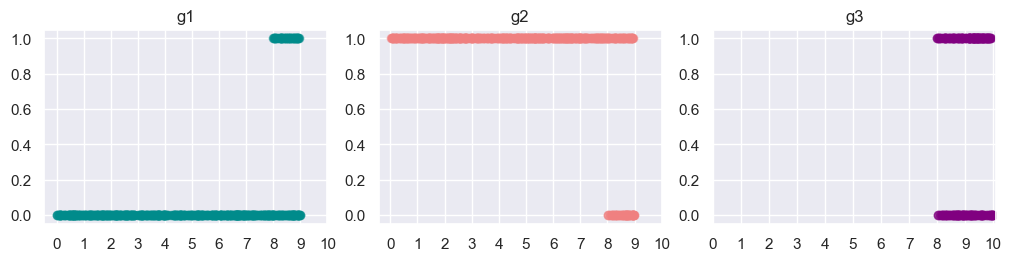

P(g1)=0.479
P(g2)=0.493
P(g3)=0.206
P(g1g2)=0.089
P(g1g2g3)=0.089


In [73]:
# Construct counterexample distribution
# thresholds for changes in P(Y = 1 | X1)
n_samples = 1000
noise = 0
X, y, [g1,g2,g3,g1g2,g1g2g3] = generate_data(n_samples=n_samples, noise=noise)
X1 = X[:,0]
X2 = X[:,1]
y0 = np.where(y == 0)
y1 = np.where(y == 1)

# Check groups are okay
fig, axs = plt.subplots(1, 3, figsize=(10, 2.5), layout='constrained')
xticks = range(11)
axs[0].scatter(X1[g1], X2[g1], alpha=0.5, color="darkcyan")
axs[0].set_xticks(xticks)
axs[0].set_title("g1")
axs[1].scatter(X1[g2], X2[g2], alpha=0.5, color="lightcoral")
axs[1].set_xticks(xticks)
axs[1].set_title("g2")
axs[2].scatter(X1[g3], X2[g3], alpha=0.5, color="purple" )
axs[2].set_xticks(xticks)
axs[2].set_title("g3")
plt.show()

# Mass of each group and intersection
print("P(g1)={}".format(len(X[g1])/n_samples))
print("P(g2)={}".format(len(X[g2])/n_samples))
print("P(g3)={}".format(len(X[g3])/n_samples))
print("P(g1g2)={}".format(len(X[g1g2])/n_samples))
print("P(g1g2g3)={}".format(len(X[g1g2g3])/n_samples))

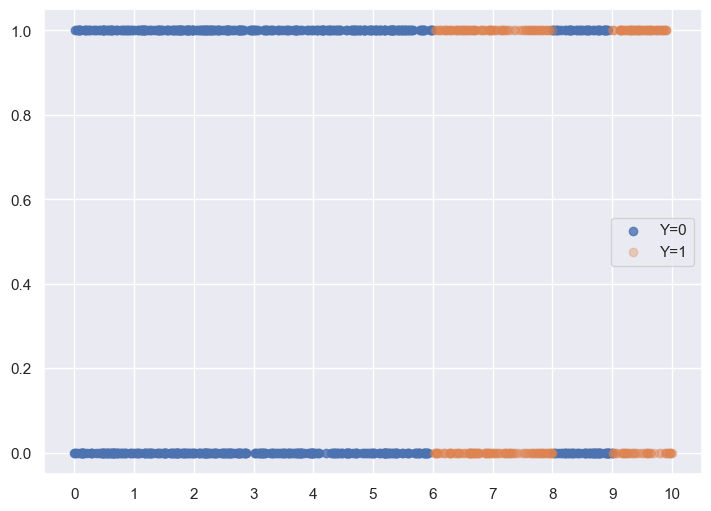

P(Y = 1)=0.335
P(Y = 1 | g1)=0.2359081419624217
P(Y = 1 | g2)=0.2129817444219067
P(Y = 1 | g3)=0.5679611650485437
P(Y = 1 | g1g2)=0.0
P(Y = 1 | g1g2g3)=0.0


In [74]:
# Plot where Y = 1 (and Y = 0)
fig, ax = plt.subplots(1, 1, figsize=(7, 5), layout='constrained')
ax.set_xticks(xticks)
ax.scatter(X[y0][:,0], X[y0][:,1], alpha=0.8)
ax.scatter(X[y1][:,0], X[y1][:,1], alpha=0.33)
ax.legend(['Y=0', 'Y=1'])
plt.show()

# P(Y = 1) statistics
print("P(Y = 1)={}".format(len(y1[0])/n_samples))
print("P(Y = 1 | g1)={}".format(len(np.intersect1d(y1, g1))/len(g1)))
print("P(Y = 1 | g2)={}".format(len(np.intersect1d(y1, g2))/len(g2)))
print("P(Y = 1 | g3)={}".format(len(np.intersect1d(y1, g3))/len(g3)))
print("P(Y = 1 | g1g2)={}".format(len(np.intersect1d(y1, g1g2))/len(g1g2)))
print("P(Y = 1 | g1g2g3)={}".format(len(np.intersect1d(y1, g1g2g3))/len    (g1g2g3)))

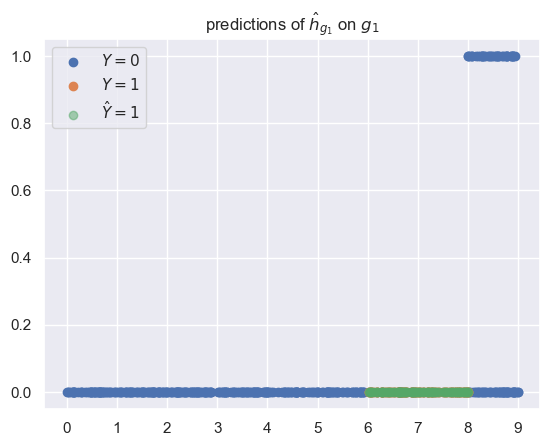

In [96]:
# Sanity check g1
plt.figure()
plt.xticks(xticks)
plt.scatter(X[np.intersect1d(y0, g1)][:,0], X[np.intersect1d(y0,g1)][:,1])
plt.scatter(X[np.intersect1d(y1, g1)][:,0], X[np.intersect1d(y1,g1)][:,1])

modelg1 = DecisionTreeClassifier(max_depth=4)
modelg1.fit(X[g1], y[g1])
ypredg1 = modelg1.predict(X)
ypredg1 = np.where(ypredg1 == 1)

plt.scatter(X[np.intersect1d(ypredg1, g1)][:,0], 
            X[np.intersect1d(ypredg1,g1)][:,1], alpha=0.5)
plt.title("predictions of $\hat{h}_{g_1}$ on $g_1$")
plt.legend(['$Y = 0$', '$Y = 1$', '$\hat{Y}=1$'])
plt.show()

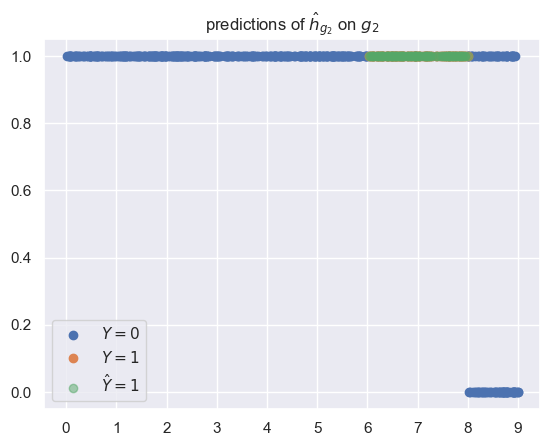

In [97]:
# Sanity check g2
plt.figure()
plt.xticks(xticks)
plt.scatter(X[np.intersect1d(y0, g2)][:,0], X[np.intersect1d(y0,g2)][:,1])
plt.scatter(X[np.intersect1d(y1, g2)][:,0], X[np.intersect1d(y1,g2)][:,1])

modelg2 = DecisionTreeClassifier(max_depth=4)
modelg2.fit(X[g2], y[g2])
ypredg2 = modelg2.predict(X)
ypredg2 = np.where(ypredg2 == 1)

plt.title("predictions of $\hat{h}_{g_2}$ on $g_2$")
plt.scatter(X[np.intersect1d(ypredg2, g2)][:,0], 
            X[np.intersect1d(ypredg2,g2)][:,1], alpha=0.5)
plt.legend(['$Y = 0$', '$Y = 1$', '$\hat{Y}=1$'])
plt.show()

In [98]:
# Agreement on g1g2
print("L(h1 | g1) = {}".format(1 - accuracy_score(modelg1.predict(X[g1]), 
                                                  y[g1])))
print("L(h2 | g2) = {}".format(1 - accuracy_score(modelg2.predict(X[g2]), 
                                                  y[g2])))
print("Agreement on g1g2: {}".format(accuracy_score(modelg1.predict(X[g1g2]),
                                                    modelg2.predict(X[g1g2]))))

L(h1 | g1) = 0.0
L(h2 | g2) = 0.0
Agreement on g1g2: 1.0


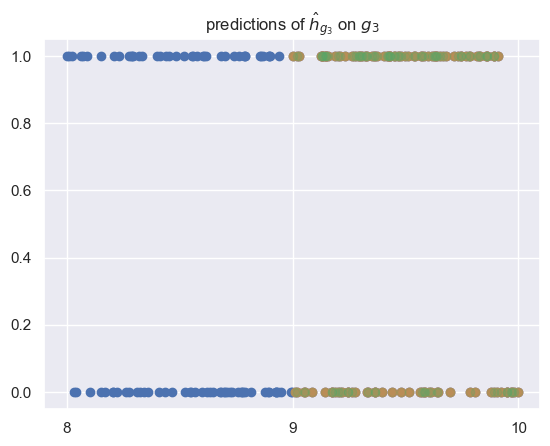

In [99]:
# Sanity check g3
plt.figure()
plt.xticks(xticks)
plt.scatter(X[g3][:,0], X[g3][:,1])
plt.scatter(X[np.intersect1d(y1, g3)][:,0], X[np.intersect1d(y1,g3)][:,1])

modelg3 = DecisionTreeClassifier(max_depth=4)
modelg3.fit(X[g3], y[g3])
ypredg3 = modelg3.predict(X)
ypredg3 = np.where(ypredg3 == 1)

plt.title("predictions of $\hat{h}_{g_3}$ on $g_3$")
plt.scatter(X[np.intersect1d(ypredg3, g3)][:,0], 
            X[np.intersect1d(ypredg3,g3)][:,1], alpha=0.25)
plt.show()


In [100]:
# Agreement on g1g2g3
print("L(h3 | g3) = {}".format(1 - accuracy_score(modelg3.predict(X[g3]), 
                                                  y[g3])))
print("Agreement on g1g2g3={}".format(accuracy_score(modelg1.predict(X[g1g2g3]),
                                                modelg3.predict(X[g1g2g3]))))

L(h3 | g3) = 0.0
Agreement on g1g2g3=1.0


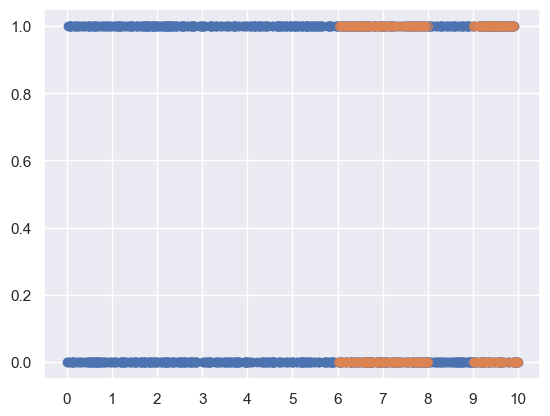

In [116]:
rf = RandomForestClassifier(n_estimators=10, max_depth=4)
rf.fit(X, y)
plt.figure()
plt.xticks(xticks)
plt.scatter(X[:,0], X[:,1])
ypred = rf.predict(X)
ypred = np.where(ypred == 1)

plt.scatter(X[ypred][:,0], 
            X[ypred][:,1], alpha=0.5)

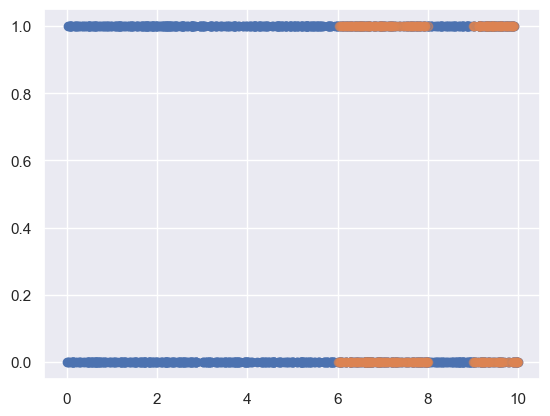

In [117]:
plt.scatter(X[:,0], X[:,1])
plt.scatter(X[y1][:,0], X[y1][:,1], alpha=0.5)

In [125]:
print("L(rf | g1)={}".format(accuracy_score(rf.predict(X[g1]), y[g1])))
print("L(h1 | g3)={}".format(accuracy_score(modelg1.predict(X[g1]), y[g1])))

print("L(rf | g2)={}".format(accuracy_score(rf.predict(X[g2]), y[g2])))
print("L(h2 | g3)={}".format(accuracy_score(modelg2.predict(X[g2]), y[g2])))

print("L(rf | g3)={}".format(accuracy_score(rf.predict(X[g3]), y[g3])))
print("L(h3 | g3)={}".format(accuracy_score(modelg3.predict(X[g3]), y[g3])))

L(rf | g1)=1.0
L(h1 | g3)=1.0
L(rf | g2)=1.0
L(h2 | g3)=1.0
L(rf | g3)=1.0
L(h3 | g3)=1.0


## Experiment 1: Vary noise level => Training Error Gap

In [229]:
# Experiment setup parameters
noise_lvls = np.linspace(0, 0.5, num=25)
n_samples = 1000
bootstraps = 10
np.random.seed(41)

# parameters for trees
max_depth = 4
tree_params = {
    'max_depth': max_depth
}
rf_params = {
    'n_estimators': 50,
    'max_depth': max_depth
}

In [230]:
avg_agree = []
avg_agreeg1g2 = []

avgacc_rfall = []
avgacc_rfg1 = []
avgacc_rfg2 = []
avgacc_rfg3 = []

avgacc_h1g1 = []
avgacc_h2g2 = []
avgacc_h3g3 = []

for noise in noise_lvls:
    # generate a new sample of data to get a bootstrap avg on the agreement
    agree_g1g2 = []
    agree_g1g2g3 = []

    acc_rfall = []
    acc_rfg1 = []
    acc_rfg2 = []
    acc_rfg3 = []
    
    acc_h1g1 = []
    acc_h2g2 = []
    acc_h3g3 = []
    for i in range(bootstraps):
        X, y, [g1,g2,g3,g1g2,g1g2g3] = generate_data(n_samples=n_samples,
                                                    noise=noise)
        
        # Train classifiers
        h1 = DecisionTreeClassifier(**tree_params)
        h1.fit(X[g1], y[g1])
        h2 = DecisionTreeClassifier(**tree_params)
        h2.fit(X[g2], y[g2])
        h3 = DecisionTreeClassifier(**tree_params)
        h3.fit(X[g3], y[g3])
        rf = RandomForestClassifier(**rf_params)
        rf.fit(X, y)

        # Get agreement
        agree_g1g2.append(accuracy_score(h1.predict(X[g1g2]), 
                                               h2.predict(X[g1g2])))
        agree_g1g2g3.append(accuracy_score(h1.predict(X[g1g2g3]),
                                                 h3.predict(X[g1g2g3])))
        
        # Get training accuracies
        acc_rfall.append(accuracy_score(rf.predict(X), y))
        acc_rfg1.append(accuracy_score(rf.predict(X[g1]), y[g1]))
        acc_rfg2.append(accuracy_score(rf.predict(X[g2]), y[g2]))
        acc_rfg3.append(accuracy_score(rf.predict(X[g3]), y[g3]))

        acc_h1g1.append(accuracy_score(h1.predict(X[g1]), y[g1]))
        acc_h2g2.append(accuracy_score(h2.predict(X[g2]), y[g2]))
        acc_h3g3.append(accuracy_score(h3.predict(X[g3]), y[g3]))

    # Get average agreement
    avg_agreeg1g2.append(sum(agree_g1g2)/ len(agree_g1g2))
    avg_agree.append(sum(agree_g1g2g3)/len(agree_g1g2g3))
    
    # Get average accuracies
    avgacc_rfall.append(sum(acc_rfall)/len(acc_rfall))
    avgacc_rfg1.append(sum(acc_rfg1)/len(acc_rfg1))
    avgacc_rfg2.append(sum(acc_rfg2)/len(acc_rfg2))
    avgacc_rfg3.append(sum(acc_rfg3)/len(acc_rfg3))

    avgacc_h1g1.append(sum(acc_h1g1)/len(acc_h1g1))
    avgacc_h2g2.append(sum(acc_h2g2)/len(acc_h2g2))
    avgacc_h3g3.append(sum(acc_h3g3)/len(acc_h3g3))

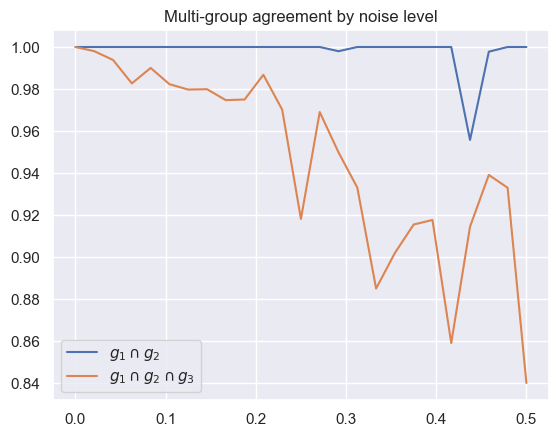

In [231]:
# Plot 1: Agreement
fig, ax = plt.subplots()
ax.plot(noise_lvls, avg_agreeg1g2, label='$g_1 \cap g_2$')
ax.plot(noise_lvls, avg_agree, label='$g_1 \cap g_2 \cap g_3$')
ax.set_title('Multi-group agreement by noise level')
ax.legend()
plt.show()

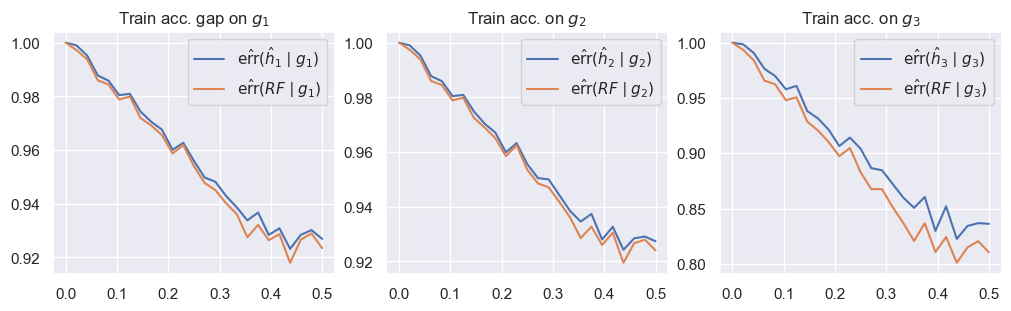

In [233]:
# Plot 2: Error of h3 vs rf on g3
fig, axs = plt.subplots(1, 3, figsize=(10, 3), layout='constrained')

# g1
axs[0].plot(noise_lvls, avgacc_h1g1, 
        label='$\hat{\mathrm{err}}(\hat{h}_1 \mid g_1)$')
axs[0].plot(noise_lvls, avgacc_rfg1, 
        label='$\hat{\mathrm{err}}(RF \mid g_1)$')
axs[0].set_title('Train acc. gap on $g_1$')
axs[0].legend()

# g2
axs[1].plot(noise_lvls, avgacc_h2g2, 
        label='$\hat{\mathrm{err}}(\hat{h}_2 \mid g_2)$')
axs[1].plot(noise_lvls, avgacc_rfg2, 
        label='$\hat{\mathrm{err}}(RF \mid g_2)$')
axs[1].set_title('Train acc. on $g_2$')
axs[1].legend()

# g3
axs[2].plot(noise_lvls, avgacc_h3g3, 
        label='$\hat{\mathrm{err}}(\hat{h}_3 \mid g_3)$')
axs[2].plot(noise_lvls, avgacc_rfg3, 
        label='$\hat{\mathrm{err}}(RF \mid g_3)$')
axs[2].set_title('Train acc. on $g_3$')
axs[2].legend()
plt.show()

## Experiment 2: Vary noise level => Test Error Gap